In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 23.9 MB 398 kB/s eta 0:00:01
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.0
    Uninstalling gensim-4.0.0:
      Successfully uninstalled gensim-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
pyldavis 3.3.1 requires pandas>=1.2.0, but you have pandas 1.1.5 which is incompatible.
     |████████████████████████████████| 9.9 MB 5.9 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [5]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [6]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [7]:
df.head(5)

AttributeError: 'NotebookFormatter' object has no attribute 'get_result'

   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  

In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 786 ms, sys: 23.7 ms, total: 810 ms
Wall time: 810 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

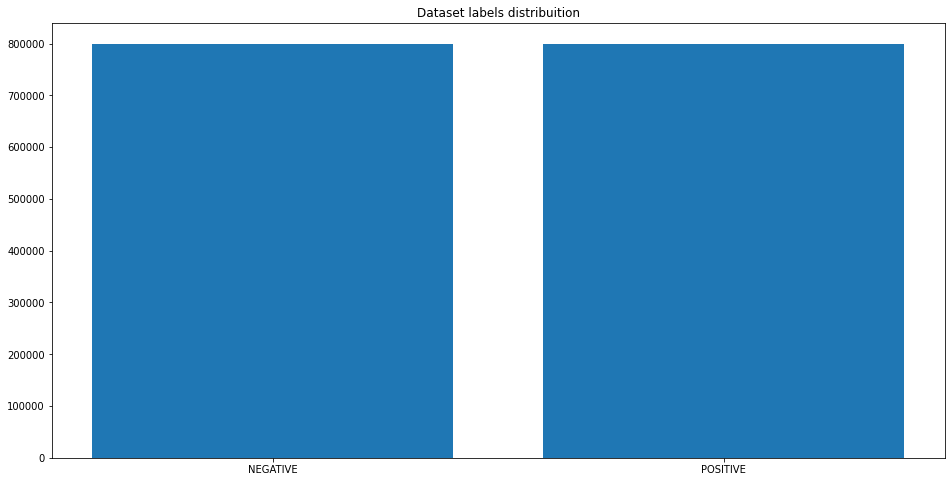

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min, sys: 253 ms, total: 1min
Wall time: 1min 2s


In [14]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [15]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.21 s, sys: 407 ms, total: 3.61 s
Wall time: 3.61 s


In [16]:
import multiprocessing

from gensim.models import Word2Vec

In [17]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [22]:
w2v_model.build_vocab(documents)

In [23]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [24]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 24min 39s, sys: 8.77 s, total: 24min 48s
Wall time: 13min 59s


(263129599, 295270528)

In [26]:
w2v_model.wv.most_similar("hate")

[('hates', 0.5583321452140808),
 ('sucks', 0.5007548928260803),
 ('stupid', 0.46589070558547974),
 ('suck', 0.4639453589916229),
 ('dislike', 0.4555560052394867),
 ('despise', 0.4432801902294159),
 ('hating', 0.4093199074268341),
 ('ugh', 0.405272513628006),
 ('annoying', 0.3924545645713806),
 ('h8', 0.38402312994003296)]

In [27]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 22.2 s, sys: 144 ms, total: 22.4 s
Wall time: 22.8 s


In [28]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 36.3 s, sys: 743 ms, total: 37 s
Wall time: 37.2 s


In [29]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [30]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [31]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [32]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [33]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [34]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [35]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [36]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [37]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [38]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 726s 642ms/step - loss: 0.5263 - accuracy: 0.7328 - val_loss: 0.4657 - val_accuracy: 0.7792
Epoch 2/8
1125/1125 [==============================] - 731s 650ms/step - loss: 0.4810 - accuracy: 0.7652 - val_loss: 0.4573 - val_accuracy: 0.7844
Epoch 3/8
1125/1125 [==============================] - 729s 648ms/step - loss: 0.4719 - accuracy: 0.7718 - val_loss: 0.4520 - val_accuracy: 0.7863
Epoch 4/8
1125/1125 [==============================] - 723s 642ms/step - loss: 0.4680 - accuracy: 0.7744 - val_loss: 0.4513 - val_accuracy: 0.7876
Epoch 5/8
1125/1125 [==============================] - 723s 643ms/step - loss: 0.4653 - accuracy: 0.7759 - val_loss: 0.4492 - val_accuracy: 0.7890
Epoch 6/8
1125/1125 [==============================] - 726s 646ms/step - loss: 0.4629 - accuracy: 0.7770 - val_loss: 0.4468 - val_accuracy: 0.7902
Epoch 7/8
1125/1125 [==============================] - 721s 641ms/step - loss: 0.4616 - accuracy: 0.7784 - val_loss: 0

In [39]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 58s 183ms/step - loss: 0.4454 - accuracy: 0.7913

ACCURACY: 0.791321873664856
LOSS: 0.4454396963119507
CPU times: user 1min 2s, sys: 1.16 s, total: 1min 3s
Wall time: 58.1 s


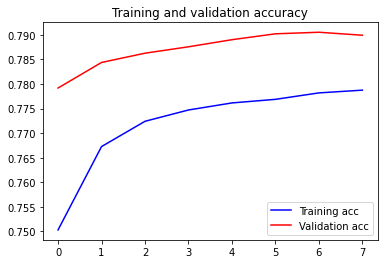

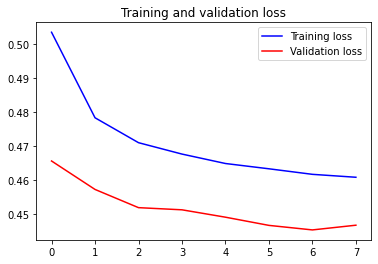

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [43]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [44]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [45]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9721642732620239,
 'elapsed_time': 0.40931034088134766}

In [46]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.008840073831379414,
 'elapsed_time': 0.1280841827392578}

In [59]:
predict("I don't know what I'm doing")

{'label': 'NEGATIVE',
 'score': 0.2948128879070282,
 'elapsed_time': 0.12407922744750977}

In [53]:
predict("RDBMS is an interesting subject")

{'label': 'POSITIVE',
 'score': 0.8594121932983398,
 'elapsed_time': 0.13745665550231934}

In [58]:
predict("Local trains make it easy to commute")

{'label': 'POSITIVE',
 'score': 0.7000029683113098,
 'elapsed_time': 0.12720346450805664}

In [49]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 45s 1s/step
CPU times: user 47 s, sys: 6.76 s, total: 53.7 s
Wall time: 46.7 s


In [50]:
#Classification Report
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.79      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [51]:
#Accuracy Score
accuracy_score(y_test_1d, y_pred_1d)

0.791321875

In [52]:
#Save Model
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)